# Project 3


## Problem Statment: 

**In this project, we want to see if we can tell apart posts from two popular subreddits: datascience and wallstreetbets, or any two subreddits or categories a text might belong to in general. Can we create a simple tool that accurately says which group a post is more likely to come from? And what words or phrases give us the best clues about this?**

In [140]:
import praw
import pandas as pd
import nltk
import pandas as np
import unicodedata
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

from nltk.tokenize.toktok import ToktokTokenizer
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer,TfidfVectorizer
from sklearn.model_selection import train_test_split 
from textblob import Word
import numpy as np
import spacy
import re
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from sklearn.feature_extraction.text import CountVectorizer
import plotly.express as px
from sklearn.manifold import TSNE
from sklearn.svm import LinearSVC


In [2]:
reddit = praw.Reddit(
    client_id='zus9cDU7x8IncmqOLReFYA',
    client_secret='3O1U8qnB3GGxPE4UtM3tpTq1qMuXfA',
    user_agent='Pro3',
    username='-__A__-',
    password=''
)

In [3]:
# Below is JUST an example of how you can use PRAW

# Choose your subreddit
subreddit_DataScience = reddit.subreddit('DataScience')
subreddit_wallstreetbets = reddit.subreddit('wallstreetbets')

# Adjust the limit as needed -- Note that this will grab the 25 most recent posts
posts_DS = subreddit_DataScience.new(limit=2525)
posts_wsb = subreddit_wallstreetbets.new(limit=2525)

In [4]:
data = []
for post in posts_DS:
    data.append([post.title, post.selftext, post.subreddit])

# Turn into a dataframe
datascience = pd.DataFrame(data, columns = ['title', 'self_text', 'subreddit'])
datascience.head()

,title,self_text,subreddit
0,What Every Developer Should Know About GPU Com...,,datascience
1,Do you use CRUD or like apps to bridge the gap...,In my about 5 years of experience working for ...,datascience
2,Anybody ever been drug tested for handling sen...,I am currently a DA for a company that uses da...,datascience
3,Any data imputation technique shares?,"Hello, \n\nI’ve been reading up some articles ...",datascience
4,Application of classical time series and deep ...,,datascience


In [5]:
data_wsb = []
for post in posts_wsb:
    data_wsb.append([post.title, post.selftext, post.subreddit])

# Turn into a dataframe
wsb = pd.DataFrame(data_wsb, columns = ['title', 'self_text', 'subreddit'])
wsb.head()

,title,self_text,subreddit
0,How Can I Bet Against the US Defaulting on Debt?,With the US slipping into 33.5 trillion of deb...,wallstreetbets
1,Corporate Bankruptcies - next shoe...,,wallstreetbets
2,Seeking wisdom,Tesla announced their earnings and the stock w...,wallstreetbets
3,"Hedge funds, Pension funds, Banks, CEOs and th...",,wallstreetbets
4,"Bulls: ""WE ARE SO OVERSOLD"" .. Reality:",,wallstreetbets


In [6]:
df = pd.concat([datascience, wsb])


In [7]:
df.subreddit.value_counts()

datascience       860
wallstreetbets    717
Name: subreddit, dtype: int64

In [8]:
df.head()

,title,self_text,subreddit
0,What Every Developer Should Know About GPU Com...,,datascience
1,Do you use CRUD or like apps to bridge the gap...,In my about 5 years of experience working for ...,datascience
2,Anybody ever been drug tested for handling sen...,I am currently a DA for a company that uses da...,datascience
3,Any data imputation technique shares?,"Hello, \n\nI’ve been reading up some articles ...",datascience
4,Application of classical time series and deep ...,,datascience


In [9]:
df.tail()

,title,self_text,subreddit
712,Giving MCD the big DD,The McRib is back (again). logically speaking ...,wallstreetbets
713,Banner bank at risk banr,Does anyone know the rumors around which bank ...,wallstreetbets
714,Meta laying off most of Metaverse teams,“Meta (META.O) is planning to lay off employee...,wallstreetbets
715,Mortgage rates just hit 8%,"Student loan payments start again this month, ...",wallstreetbets
716,Microsoft Needs So Much Power to Train AI That...,Invest in small nuclear reactor manufacturers,wallstreetbets


### 

### Shuffling the DataFrame 

In [10]:
df = df.sample(frac = 1)
df[:10]

,title,self_text,subreddit
71,Sap ui5 fiori vs data science,I'm in a part of my life where I hate my job. ...,datascience
783,PG Certification in Business Data Analytics,Hey!\n\nDo you have any reviews on the above m...,datascience
205,SHAP Deep Reinforcement Learning,"Hi Guys,\n\nIs there a way to integrate SHAP w...",datascience
537,AAA service trucks are using Rivians now,,wallstreetbets
304,What do corporate data scientists struggle wit...,"As a data scientist, if you could let someone ...",datascience
521,"Idea for a Tool - ""Define your data science pr...","Hey guys, I've worked with a lot of clients th...",datascience
226,"Daily Discussion Thread for October 16, 2023",**Join **[**WSB's community voice chat**](http...,wallstreetbets
232,How a slick accounting maneuver led to a $29 b...,,wallstreetbets
7,Data Structures & Algorithms in Data Science,hi ppl. I'm wondering if it is useful to learn...,datascience
363,Quantifying picture component to a whole,Simple example would be chopping a square into...,datascience


### Fearture engineering and pre-processing

Merging title and self_text

In [11]:
df['post'] = df.apply(lambda row: f"title: {row['title']} text: {row['self_text']}", axis=1)
df.head()

,title,self_text,subreddit,post
71,Sap ui5 fiori vs data science,I'm in a part of my life where I hate my job. ...,datascience,title: Sap ui5 fiori vs data science text: I'm...
783,PG Certification in Business Data Analytics,Hey!\n\nDo you have any reviews on the above m...,datascience,title: PG Certification in Business Data Analy...
205,SHAP Deep Reinforcement Learning,"Hi Guys,\n\nIs there a way to integrate SHAP w...",datascience,title: SHAP Deep Reinforcement Learning text: ...
537,AAA service trucks are using Rivians now,,wallstreetbets,title: AAA service trucks are using Rivians no...
304,What do corporate data scientists struggle wit...,"As a data scientist, if you could let someone ...",datascience,title: What do corporate data scientists strug...


In [12]:
df.drop(['title','self_text'], axis=1, inplace=True)

In [ ]:
df.head()

,subreddit,post
71,datascience,title: Sap ui5 fiori vs data science text: I'm...
783,datascience,title: PG Certification in Business Data Analy...
205,datascience,title: SHAP Deep Reinforcement Learning text: ...
537,wallstreetbets,title: AAA service trucks are using Rivians no...
304,datascience,title: What do corporate data scientists strug...


### Preprocessing
I making use of Regex to remove numbers and links from the post and creating a new column called cleaned post with processed text.

In [14]:
pattern = r'\b\d+\b|http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
df['cleaned_post'] = df['post'].replace(pattern, '', regex=True)

# EDA
* Starting off with highest single word count.
* Highest bigrams count
* Highest trigram count

### We will use countvectorizer with ngram_range:
* ngram_range = (1,1) -> To do EDA on unigrams
* ngram_range = (2,2) -> To do EDA on bigrams
* ngram_range = (3,3) -> To do EDA on bigrams

In [15]:
#intitialize CountVectorizer 
vectorizer = CountVectorizer()

In [16]:
#fit 
wm = vectorizer.fit_transform(df['cleaned_post'])

In [17]:
wm.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [18]:
df_vect_ex = pd.DataFrame(wm.toarray(), columns= vectorizer.get_feature_names_out(), index=df.index)

In [19]:
df_vect_ex

,06pm,0dte,0dtes,0s,0t,0th,1000s,100_000_000,100bps,100k,...,za,zero,zhang,zhuzh,zig,zillow,zone,zones,zoom,zoomer
71,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
783,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
205,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
537,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
304,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
40,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
838,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
576,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
df_vect_ex['target_subreddit'] = df['subreddit']

In [21]:
Count_w = df_vect_ex.drop('target_subreddit', axis=1).sum().sort_values(ascending = False)

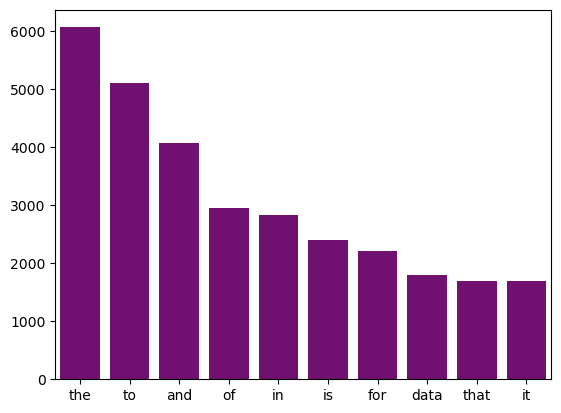

In [22]:
import seaborn as sns
sns.barplot(x=Count_w.index[:10], y = Count_w[:10], color='purple')
plt.show()

In [23]:
def gettopten(df):
    nv = CountVectorizer(stop_words='english', token_pattern= (r'\b(?!http\b|https\b|www\b|ftp\b)(?<!http)(?<!https)(?<!www)(?<!ftp)'
           r'\b[^\d\W]+\b(?!.[a-zA-Z0-9]+\b)'))
    nvv = nv.fit_transform(df['cleaned_post'])
    df_no = pd.DataFrame(nvv.toarray(), columns= nv.get_feature_names_out(), index= df.index)
    new_count = df_no.sum().sort_values(ascending=False)
    return sns.barplot(x=new_count.index[:10],y=new_count[:10], palette='colorblind') 


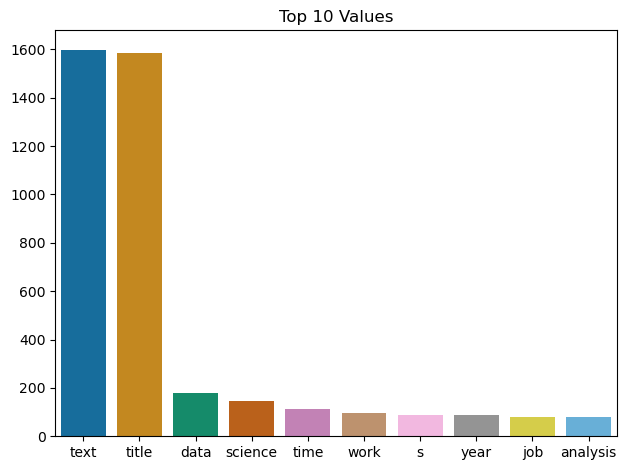

In [24]:
gettopten(df)
plt.title('Top 10 Values')
plt.tight_layout()
plt.show()


## Now we will check top 10 word counts in each subreddit

In [25]:
df[df['subreddit'] == 'datascience']

,subreddit,post,cleaned_post
71,datascience,title: Sap ui5 fiori vs data science text: I'm...,title: Sap ui5 fiori vs data science text: I'm...
783,datascience,title: PG Certification in Business Data Analy...,title: PG Certification in Business Data Analy...
205,datascience,title: SHAP Deep Reinforcement Learning text: ...,title: SHAP Deep Reinforcement Learning text: ...
304,datascience,title: What do corporate data scientists strug...,title: What do corporate data scientists strug...
521,datascience,"title: Idea for a Tool - ""Define your data sci...","title: Idea for a Tool - ""Define your data sci..."
...,...,...,...
692,datascience,title: Possibility of getting Data Science (Jr...,title: Possibility of getting Data Science (Jr...
505,datascience,title: AI Career text: I'm currently in my fir...,title: AI Career text: I'm currently in my fir...
780,datascience,title: Do people not use sci-kit learn / other...,title: Do people not use sci-kit learn / other...
838,datascience,"title: Computer for Coding text: Hi everyone, ...","title: Computer for Coding text: Hi everyone, ..."


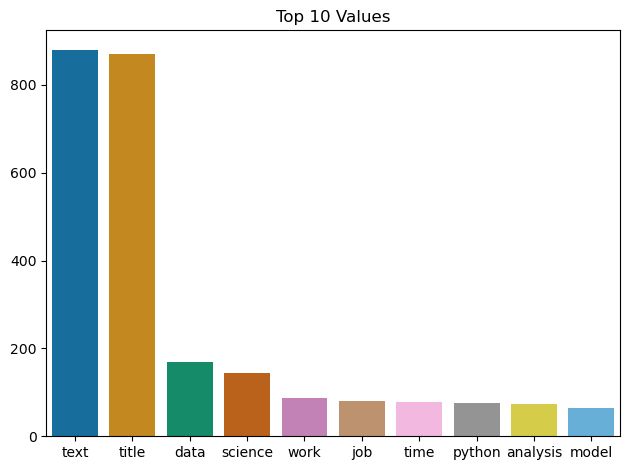

In [26]:
gettopten(df[df['subreddit'] == 'datascience'])
plt.title('Top 10 Values')
plt.tight_layout()
plt.show()

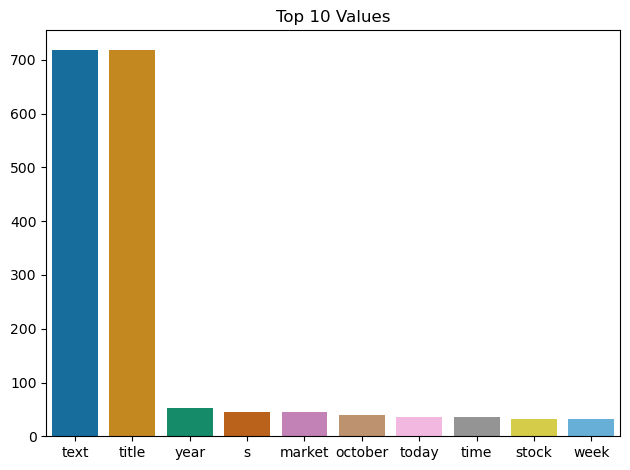

In [27]:
gettopten(df[df['subreddit'] == 'wallstreetbets'])
plt.title('Top 10 Values')
plt.tight_layout()
plt.show()

In [28]:
def gettop10(df,n,stop='english'):
    cvec = CountVectorizer(ngram_range=(n,n), stop_words= stop)

    nvv = cvec.fit_transform(df['cleaned_post'])
    df_no = pd.DataFrame(nvv.toarray(), columns= cvec.get_feature_names_out(), index= df.index)
    new_count = df_no.sum().sort_values(ascending=False)
    plt.figure(figsize=(12,6))
    plt.tight_layout()
    return sns.barplot(x=new_count[:10],y=new_count.index[:10], palette='colorblind') 

## Top 10 highest occuring bigrams in the entire dataset

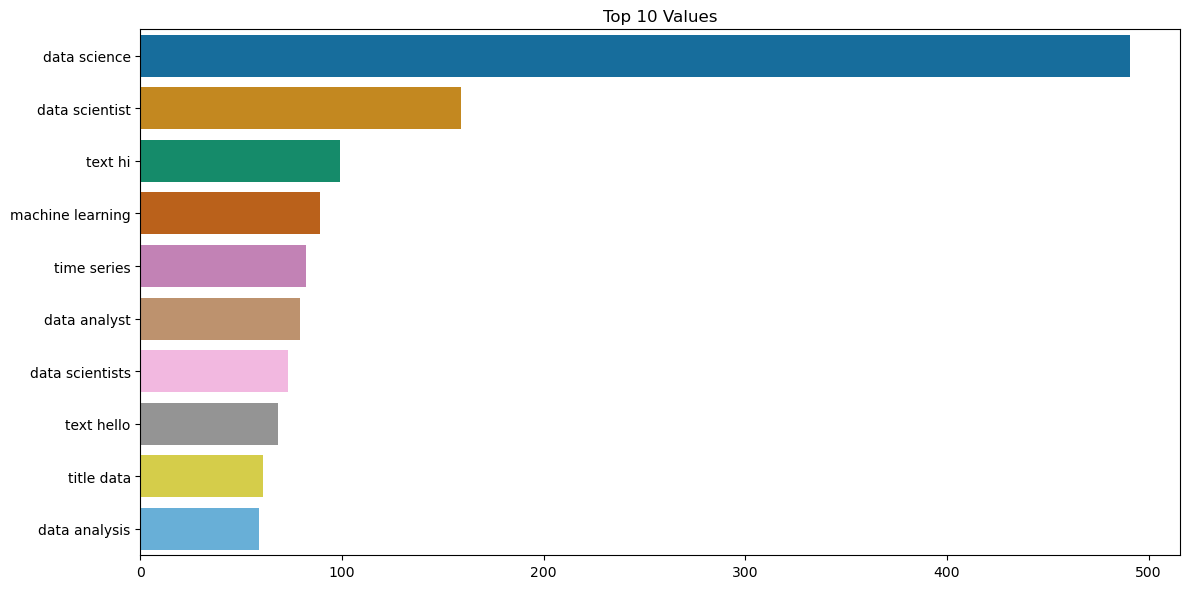

In [29]:
gettop10(df,2)
plt.title('Top 10 Values')
plt.tight_layout()
plt.show()

## Discovery:
There seems to be a word that appears frequently called `x200b`. Upon further investigation, this is the unicode for **whitespace character**. We will need to modify our post and remove this chracter with help of regex.

In [30]:
df['cleaned_post'] = df['cleaned_post'].replace(r'x200B|text|title|\n|\'', '', regex=True)

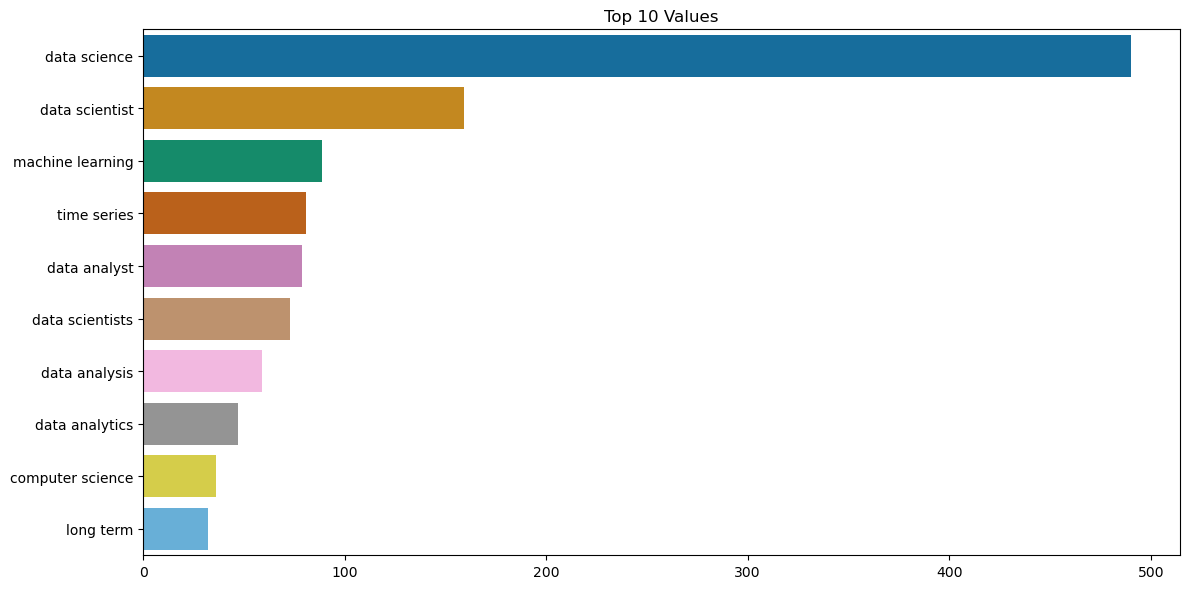

In [31]:
gettop10(df,2)
plt.title('Top 10 Values')
plt.tight_layout()
plt.show()

## Top 10 occurring bigrams in the wallstreetbets

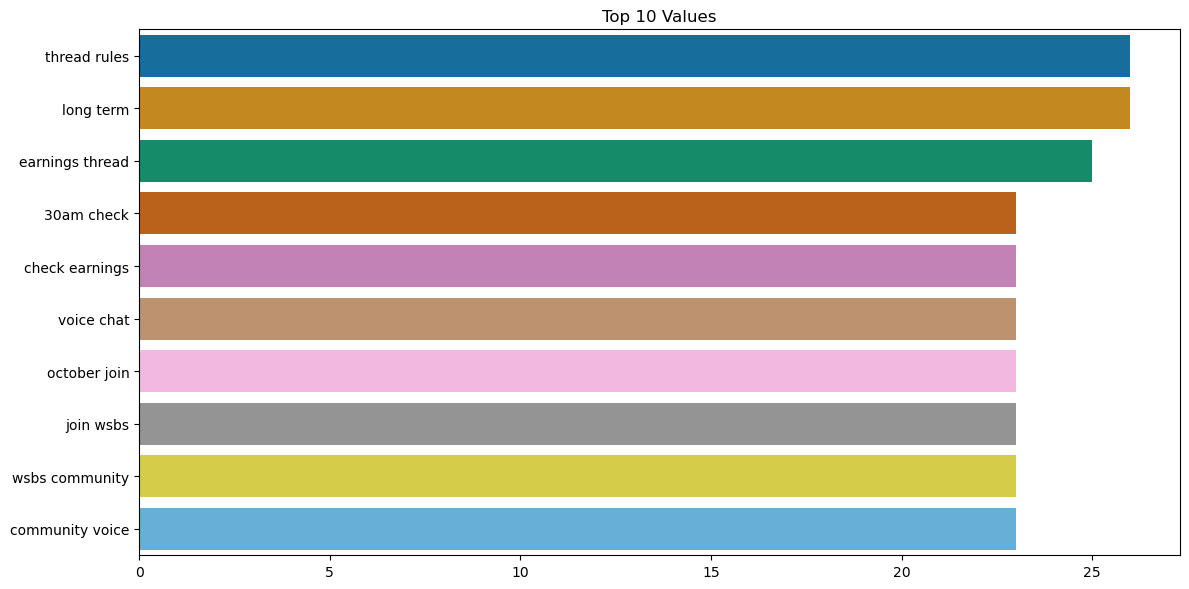

In [32]:
gettop10(df[df['subreddit'] == 'wallstreetbets'],2)
plt.title('Top 10 Values')
plt.tight_layout()
plt.show()

## Top 10 occurring bigrams in the datascience 

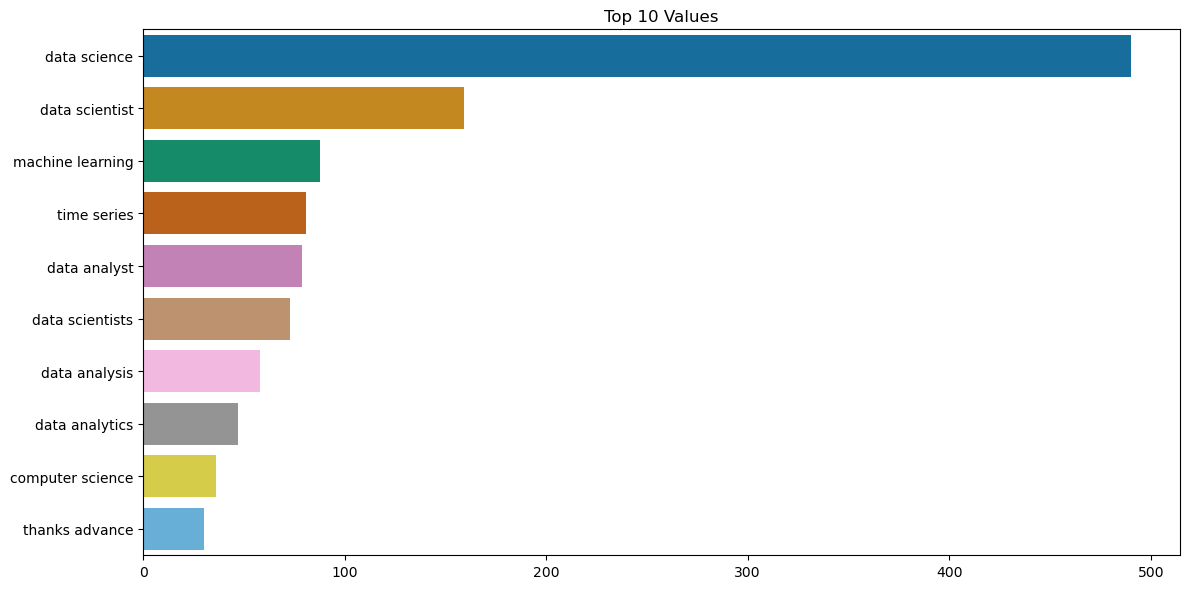

In [33]:
gettop10(df[df['subreddit'] == 'datascience'],2)
plt.title('Top 10 Values')
plt.tight_layout()
plt.show()

## Top 10 occurring trigrams in the wallstreetbets

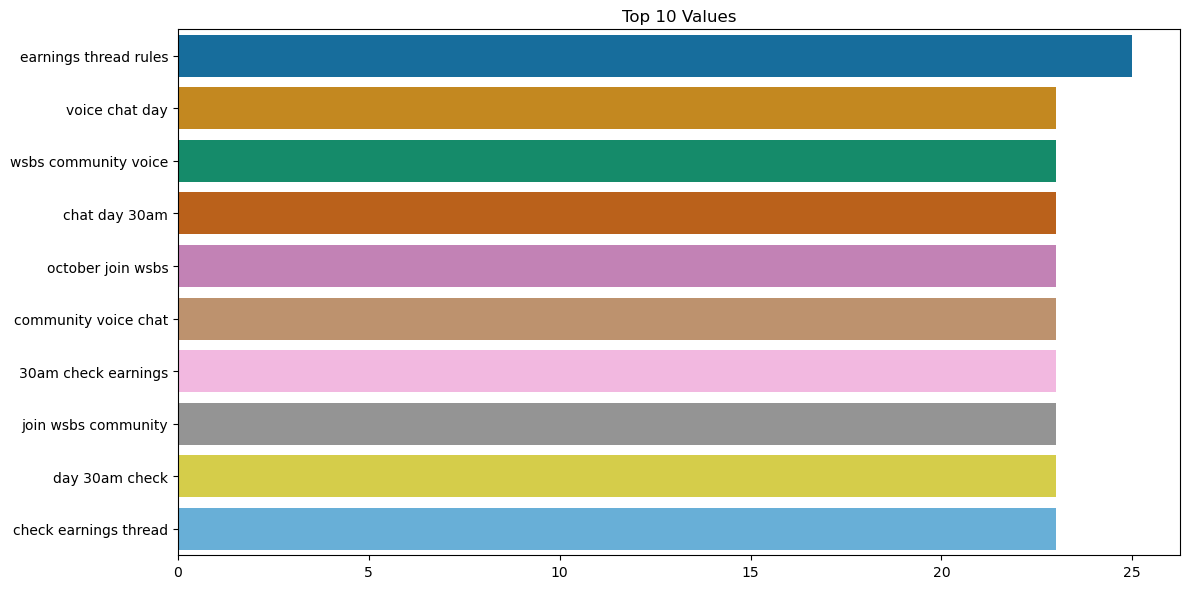

In [34]:
gettop10(df[df['subreddit'] == 'wallstreetbets'],3)
plt.title('Top 10 Values')
plt.tight_layout()
plt.show()

## Top 10 occurring trigrams in the datascience

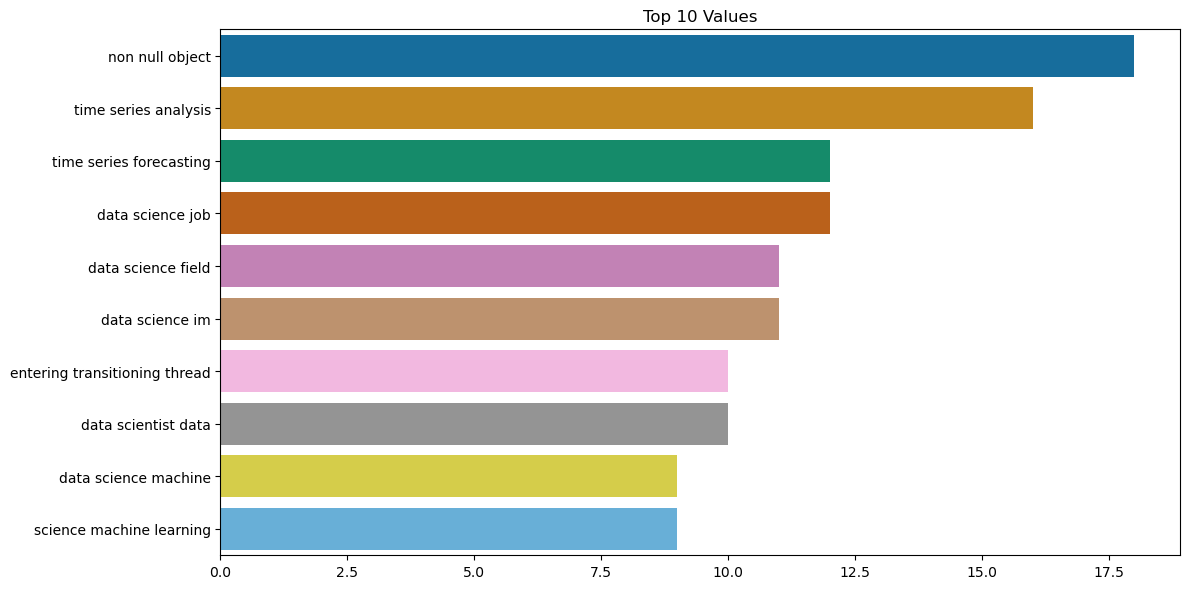

In [35]:
gettop10(df[df['subreddit'] == 'datascience'],3)
plt.title('Top 10 Values')
plt.tight_layout()
plt.show()

## Trigrams with stopwords

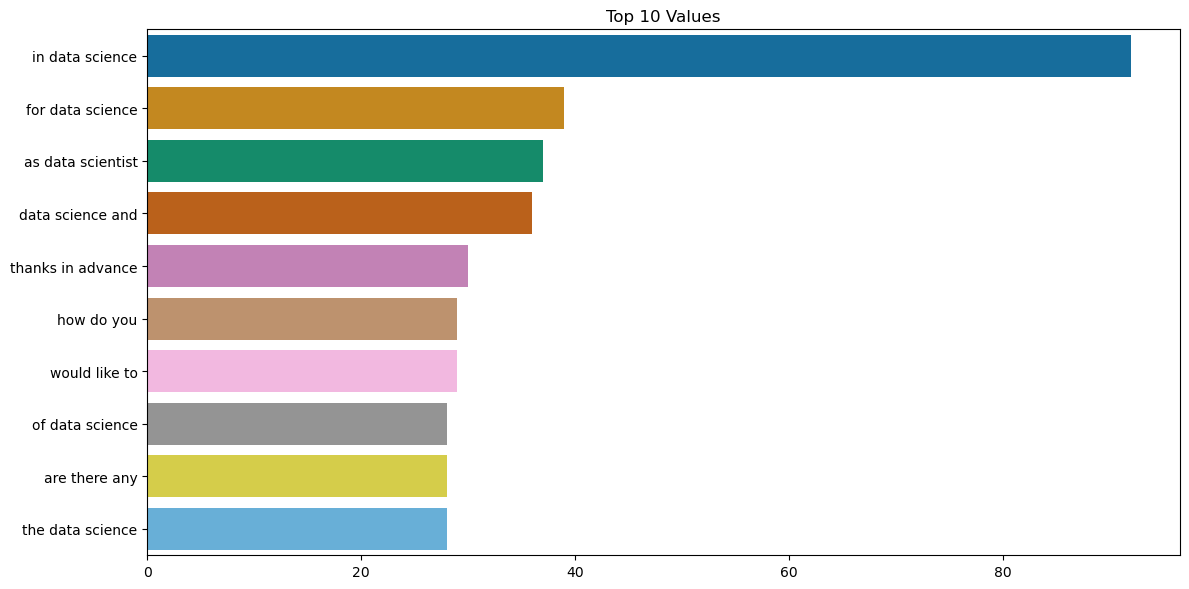

In [36]:
gettop10(df[df['subreddit'] == 'datascience'],3,stop=None)
plt.title('Top 10 Values')
plt.tight_layout()
plt.show()

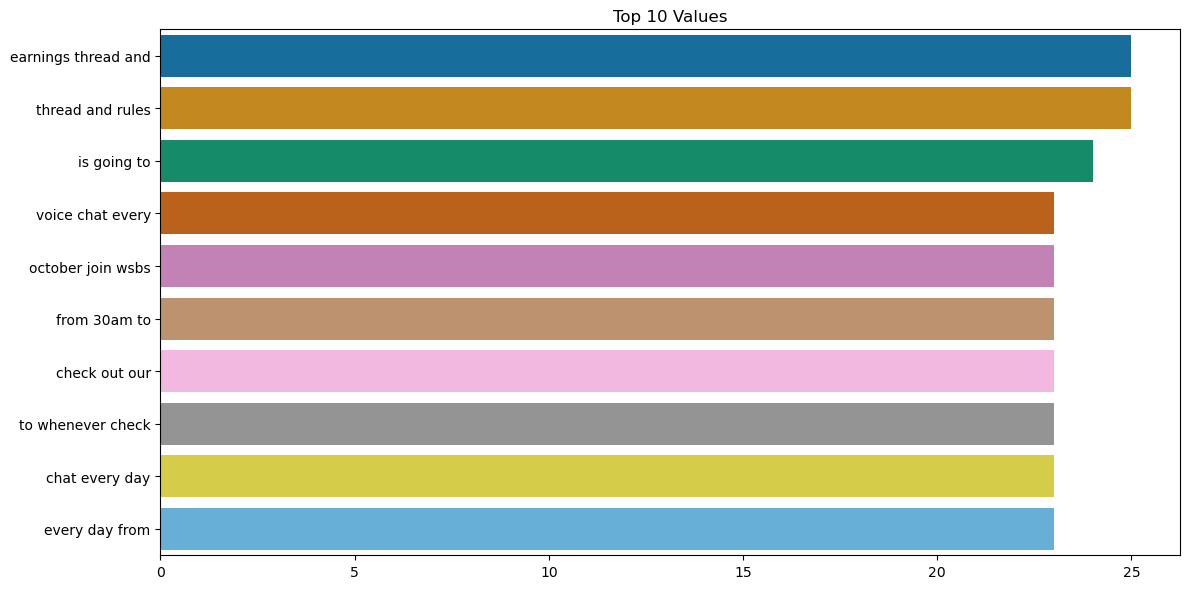

In [37]:
gettop10(df[df['subreddit'] == 'wallstreetbets'],3,stop=None)
plt.title('Top 10 Values')
plt.tight_layout()
plt.show()

## 4-gram with stopwords

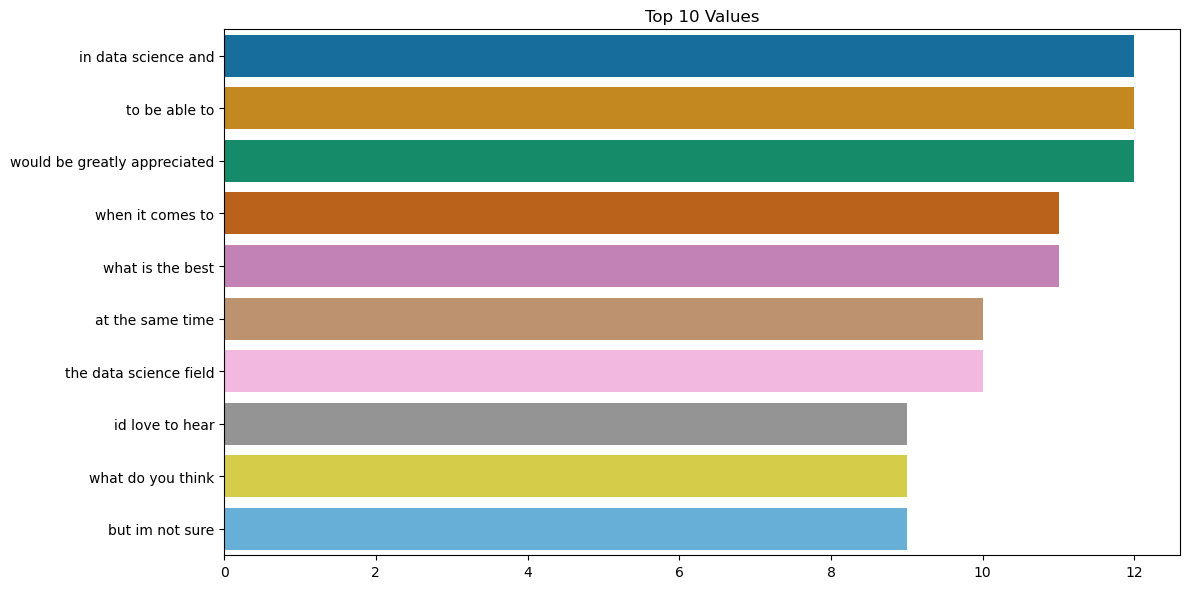

In [38]:
gettop10(df[df['subreddit'] == 'datascience'],4,stop=None)
plt.title('Top 10 Values')
plt.tight_layout()
plt.show()

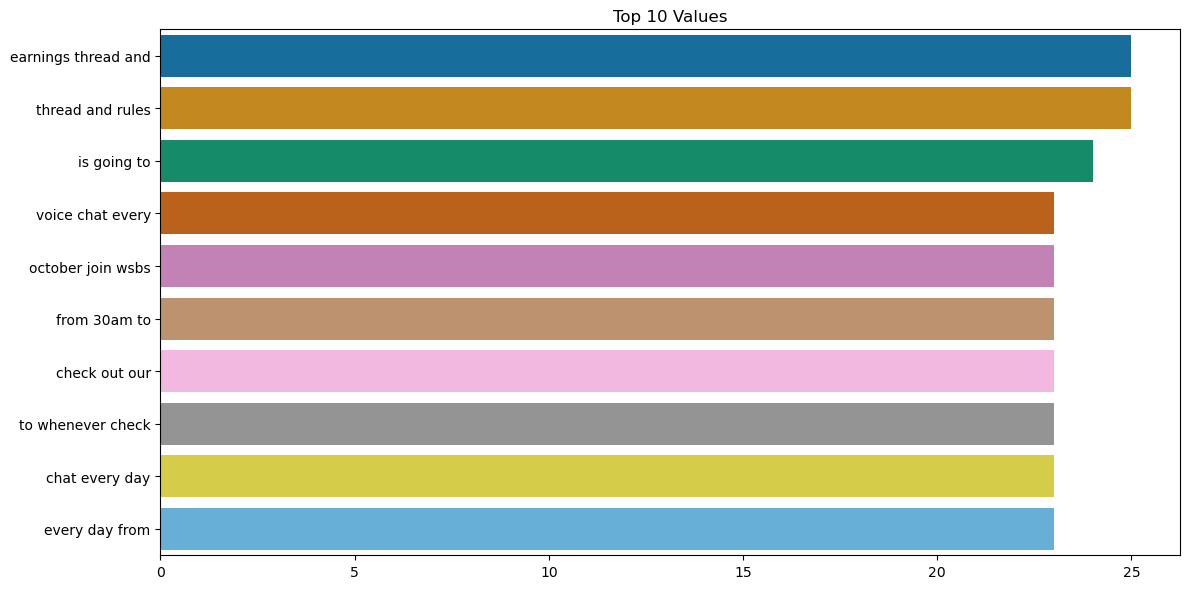

In [39]:
gettop10(df[df['subreddit'] == 'wallstreetbets'],3,stop=None)
plt.title('Top 10 Values')
plt.tight_layout()
plt.show()

## T-SNE Visulization

In [40]:
df.reset_index(drop=True, inplace=True)

In [41]:
color_palette = [ '#56B4E9', '#009E73', '#F0E442', '#0072B2', '#D55E00', '#CC79A7']
#'#E69F00', '#56B4E9','#0072B2'

In [42]:

def tsne_viz(df, n, stop='english'):
   
    cvec = TfidfVectorizer(ngram_range=(n,n), stop_words=stop)
    vectorized_matrix = cvec.fit_transform(df['cleaned_post'])
    
    tsne = TSNE(n_components=3, random_state=42)
    tsne_results = tsne.fit_transform(vectorized_matrix.toarray())
    
    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(111, projection='3d')
    
    scatter = ax.scatter(tsne_results[:,0], tsne_results[:,1], tsne_results[:,2], 
                         c=pd.factorize(df['subreddit'])[0], cmap="viridis", s=60)
    
    legend1 = ax.legend(*scatter.legend_elements(), title="Subreddits")
    ax.add_artist(legend1)
    
    ax.set_title('3D t-SNE Visualization')
    ax.set_xlabel('t-SNE Dimension 1')
    ax.set_ylabel('t-SNE Dimension 2')
    ax.set_zlabel('t-SNE Dimension 3')
    
    plt.show()



c:\Users\muham\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\muham\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


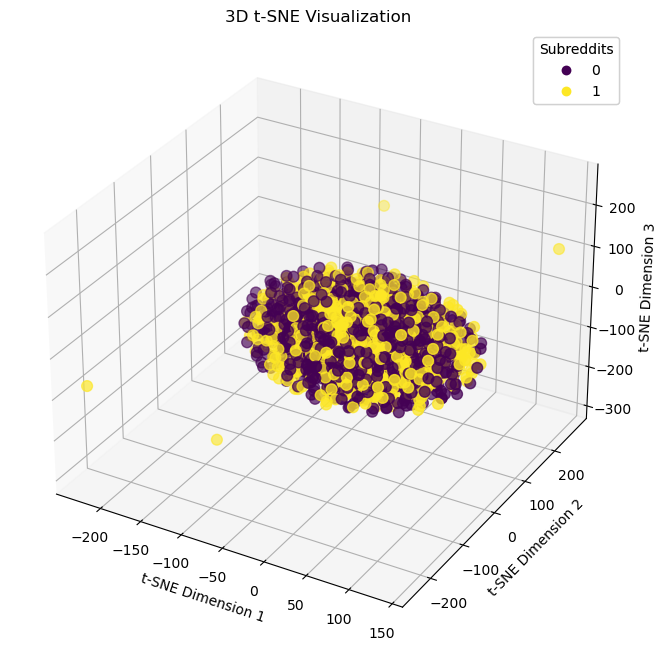

In [43]:
tsne_viz(df, 3, stop='english')

In [44]:

def tsne_vizinter(df, n, stop='english'):

    cvec = TfidfVectorizer(ngram_range=(n-1,n), stop_words=stop)
    vectorized_matrix = cvec.fit_transform(df['cleaned_post'])
       
    tsne = TSNE(n_components=3, random_state=42)
    tsne_results = tsne.fit_transform(vectorized_matrix.toarray())
   
    df_tsne = pd.DataFrame(tsne_results, columns=['dim1', 'dim2', 'dim3']).reset_index(drop=True)
    df_tsne['subreddit'] = df['subreddit'].reset_index(drop=True)
    
    fig = px.scatter_3d(df_tsne, x='dim1', y='dim2', z='dim3', color='subreddit',color_discrete_sequence=color_palette)
    fig.show()




In [45]:
tsne_vizinter(df, 3, stop='english')

c:\Users\muham\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\muham\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


We can see that bigrams and trigrams gives a mixed cluster 

In [46]:

def tsne_viz_index(df, n, stop='english'):

    cvec = TfidfVectorizer(ngram_range=(n-1,n), stop_words=stop)
    vectorized_matrix = cvec.fit_transform(df['cleaned_post'])
    
    tsne = TSNE(n_components=3, random_state=42)
    tsne_results = tsne.fit_transform(vectorized_matrix.toarray())
    
    df_tsne = pd.DataFrame(tsne_results, columns=['dim1', 'dim2', 'dim3'])
    df_tsne['subreddit'] = df['subreddit'].reset_index(drop=True)
    df_tsne['index'] = df.index  # Add the index as a column

    fig = px.scatter_3d(df_tsne, x='dim1', y='dim2', z='dim3', color='subreddit', hover_data=['index'],color_discrete_sequence=color_palette)
    fig.show()



In [47]:
tsne_viz_index(df, 2, stop='english')

c:\Users\muham\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

c:\Users\muham\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



We see unigram and bigram features give a good cluster.

In [48]:
print(df.iloc[501]['cleaned_post']),  # Checking out the outlier post in the above visuallization 
print(df.iloc[501]['subreddit'])

: My fault guys I bought  DTE Calls a minute before the drop : 
wallstreetbets


An outlier that only has a title and a : for text.

In [49]:
print(df.iloc[1148]['cleaned_post']),  # Checking out the outlier post in the above visuallization 
print(df.iloc[1148]['subreddit'])

: Isn’t Disney supposed to be under ? :       I have been watching this stock for really long time. It does look like company isn’t going to get better anytime soon. Even Ceo said in the interview that Disney is in worse shape than he thought.     Why are people still buying this stock? Is it solely because people are betting it’s going to turn around like meta?     I’m bullish on Disney but I’m just going to wait until it goes below .
wallstreetbets


This post is identified as an outlier by TSNE visulization correctly as it is talking about homw buying in the wallstreetbets subreddit.

In [50]:
print(df.iloc[59]['cleaned_post']),  # Checking out the outlier post in the above visuallization 
print(df.iloc[59]['subreddit'])

: Sick to my stomach - Lost 23K : I started with the about 8K investing at the beginning of this year. Had made it to little over 40K by end of September.  Today I disregarded all my stop loss rules, and personal limits and paid for it dearly. My mind was so set on chart patterns, Vs, and inverse Vs from all these days of trading, I was too confident that at some point, there would be a drop, and I kept buying puts on top of puts.  Let this be a lesson bools and bears.  I am really sad, angry and upset today.  Will see about Monday when Monday comes along.   
wallstreetbets


Another example of an outlier.

In [51]:
tsne_viz_index(df, 3, stop='english')

c:\Users\muham\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

c:\Users\muham\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



Trigrams and bigrams fetures give a mix cluster.

In [52]:
print(df.iloc[376]['cleaned_post']),  # Checking out the outlier post in the above visuallization 
print(df.iloc[376]['subreddit'])

: AI’s Data Cannibalism : Im looking to read more on this topic mentioned in the .&#;Feel free to suggest books and articles
datascience


This post is quite ambugious.


Further cleaning 

In [53]:
import re # Source Chat GPT

def clean_text(text):
    # Remove URLs
    text = re.sub(r'http\S+|www\S+', '', text)
    
    # Remove Emojis
    emoji_pattern = re.compile(
        u"([\U00002600-\U000027BF])|"  # Misc symbols
        u"([\U0001F600-\U0001F64F])|"  # Emoticons
        u"([\U0001F300-\U0001F5FF])|"  # Symbols & pictographs
        u"([\U0001F680-\U0001F6FF])|"  # Transport & map symbols
        u"([\U0001F700-\U0001F77F])|"  # Alchemical symbols
        u"([\U0001F780-\U0001F7FF])|"  # Geometric shapes ext
        u"([\U0001F800-\U0001F8FF])|"  # Supplemental arrows C
        u"([\U0001F900-\U0001F9FF])|"  # Supplemental symbols
        u"([\U0001FA00-\U0001FA6F])|"  # Chess symbols
        u"([\U0001FA70-\U0001FAFF])"   # Symbols and pictographs ext A
        , re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    
    # Remove excessive whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Remove placeholder text
    text = re.sub(r'Daily Discussion Thread for [A-Za-z\s]+,', '', text)
    
    return text


In [54]:
df2 = df.copy()

In [55]:
df2['cleaned_post'] = df2['cleaned_post'].apply(clean_text)

In [56]:
tsne_viz_index(df2, 3, stop='english')

c:\Users\muham\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

c:\Users\muham\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



Even after further cleaning bigrams and trigrams fetures still give a mix cluster this implies that bigrams and trigrams fetures are not a good choise for modeling purposes. 

In [57]:
print(df2.iloc[1162]['cleaned_post']) # Checking out the outlier post in the above visuallization 
print(df2.iloc[1162]['subreddit'])

: Eye Tracking Data : Hey all,I am a neuroscience Ph.D. student working with some eye-tracking data. The typical approach in my lab has been to try and fit the data to a GLM. Which is fine as a first pass, but I dont want to be limited to just that. I am curious if anyone else here has worked with eye-tracking data and can point me in the right direction. As far as the details are concerned, I am collecting eye-tracking data in few experimental cons. I would go into detail, but I want to stay at least a bit vague for privacy concerns. But to give you some idea of what I am doing, I have one task where participants are looking for a certain stimulus among distractor stimuli. The primary measurable output of this experiment is what stimulus they move their eyes to. But I am sure there is more information captured in the eye-tracking data that we can leverage. Another experiment is looking at overall gaze stability to infer cognitive mechanisms. If anyone is interested, I am willing to go

This person just posted an emoji which TSNE vizulization correctly classifies as an extrem outlier.

In [58]:
print(df2.iloc[193]['cleaned_post']) # Checking out the outlier post in the above visuallization 
print(df2.iloc[193]['subreddit'])

: Hoping on the AMC bull train :
wallstreetbets


This is the same person.

In [59]:
tsne_viz_index(df2, 4, stop='english')

c:\Users\muham\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

c:\Users\muham\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



Trigrams and 4-grams give a mixed cluster.

__The TSNE visualization shows that unigram and bigram features gives us the best clusters.__

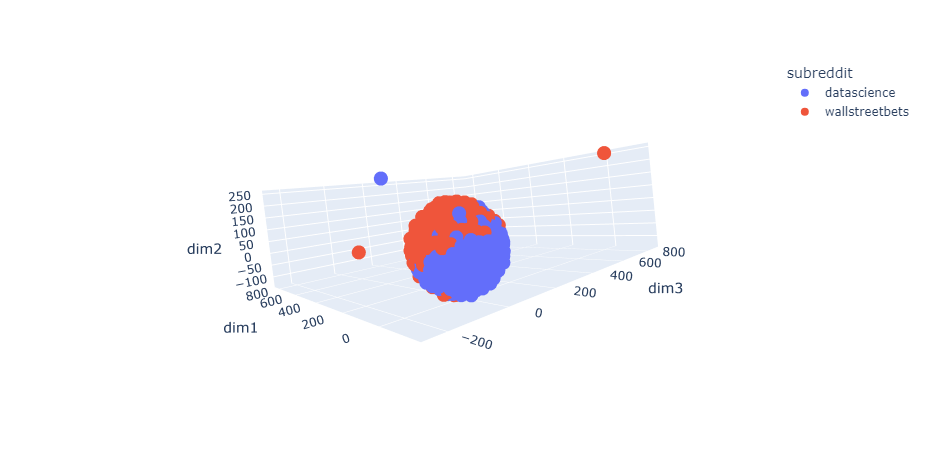


## Modeling

In [60]:
X= df2['cleaned_post']
y=df2['subreddit'].reset_index(drop=True)
y= y.apply(lambda x: x.display_name)


In [145]:
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=42)

In [177]:

pgrid = {
    'tvec__stop_words': [None, 'english'],
    'tvec__min_df': [1, 2, 3],
    'tvec__ngram_range': [(1, 1), (1, 2), (2,2)],
    'logit__penalty': ['l1','l2'],
    'logit__C': [0.0001,0.0005,0.001,0.005,0.01,0.05,0.1,0.5,1,5,10,50],
    'logit__max_iter': [ 2000],
    'logit__solver': ['liblinear']


}
  

In [178]:

pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('logit', LogisticRegression())
   ])


In [179]:
gs_tvec = GridSearchCV(pipe, pgrid, cv=10, n_jobs=6)


In [180]:
%%time
gs_tvec.fit(X_train, y_train)

Wall time: 6min 40s


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('logit', LogisticRegression())]),
             n_jobs=6,
             param_grid={'logit__C': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05,
                                      0.1, 0.5, 1, 5, 10, 50],
                         'logit__max_iter': [2000],
                         'logit__penalty': ['l1', 'l2'],
                         'logit__solver': ['liblinear'],
                         'tvec__min_df': [1, 2, 3],
                         'tvec__ngram_range': [(1, 1), (1, 2), (2, 2)],
                         'tvec__stop_words': [None, 'english']})

In [181]:
gs_tvec.score(X_test, y_test)

0.959493670886076

In [182]:
gs_tvec.best_params_

{'logit__C': 5,
 'logit__max_iter': 2000,
 'logit__penalty': 'l2',
 'logit__solver': 'liblinear',
 'tvec__min_df': 1,
 'tvec__ngram_range': (1, 1),
 'tvec__stop_words': 'english'}

## Let's Also train a SVM Model

In [185]:

pgrid_svm = {
    'tvec__stop_words': [None, 'english'],
    'tvec__min_df': [1, 2, 3],
    'tvec__ngram_range': [(1, 1), (1, 2), (2,2)],
    'svm__penalty': ['l2'], # The ‘l2’ penalty is the standard used in SVC. The ‘l1’ leads to coef_ vectors that are sparse.
    'svm__C': [0.00001,0.0001,0.0005,0.001,0.005,0.01,0.05,0.1,0.5,1,5,10,50],
    'svm__max_iter': [2000]


}
pipe_svm = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('svm', LinearSVC())
   ])
gs_tvec_SVM = GridSearchCV(pipe_svm, pgrid_svm, cv=10, n_jobs=6)


In [186]:
%%time
gs_tvec_SVM.fit(X_train, y_train)

Wall time: 59.1 s


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('svm', LinearSVC())]),
             n_jobs=6,
             param_grid={'svm__C': [1e-05, 0.0001, 0.0005, 0.001, 0.005, 0.01,
                                    0.05, 0.1, 0.5, 1, 5, 10, 50],
                         'svm__max_iter': [2000], 'svm__penalty': ['l2'],
                         'tvec__min_df': [1, 2, 3],
                         'tvec__ngram_range': [(1, 1), (1, 2), (2, 2)],
                         'tvec__stop_words': [None, 'english']})

In [187]:
gs_tvec_SVM.best_params_

{'svm__C': 0.5,
 'svm__max_iter': 2000,
 'svm__penalty': 'l2',
 'tvec__min_df': 1,
 'tvec__ngram_range': (1, 2),
 'tvec__stop_words': 'english'}

In [188]:
gs_tvec_SVM.score(X_test, y_test)

0.9670886075949368

### We have successfully trained a model that achieves 95% accuracy on the test set.

In [191]:
preds = gs_tvec.predict(["I made $1000 on the stock market today! let's go baby!", 
                         "How do I remove null objects from my dataset?",
                         "Guys I need some investment decisions, please help.",
                         "I trained a Logistic Regression model to classify the subreddits of a given post."])

In [192]:
preds

array(['wallstreetbets', 'datascience', 'wallstreetbets', 'datascience'],
      dtype=object)

In [139]:
pd.DataFrame({"input": ["I made $1000 on the stock market today! let's go baby!", 
                         "How do I remove null objects from my dataset?",
                         "Guys I need some investment decisions, please help.",
                         "I trained a Logistic Regression model to classify the subreddits of a given post."],
            "model prediction": preds})

,input,model prediction
0,I made $1000 on the stock market today! let's ...,wallstreetbets
1,How do I remove null objects from my dataset?,datascience
2,"Guys I need some investment decisions, please ...",wallstreetbets
3,I trained a Logistic Regression model to class...,datascience


### Conclusion:

* We crawled reddit using PRAW and pulled posts from two subreddits, `datascience` and `wallstreetbets`.
* We performed EDA on the WordCount occuring in each subreddit and found promising results:  
* Datascience subreddit bigram counts: 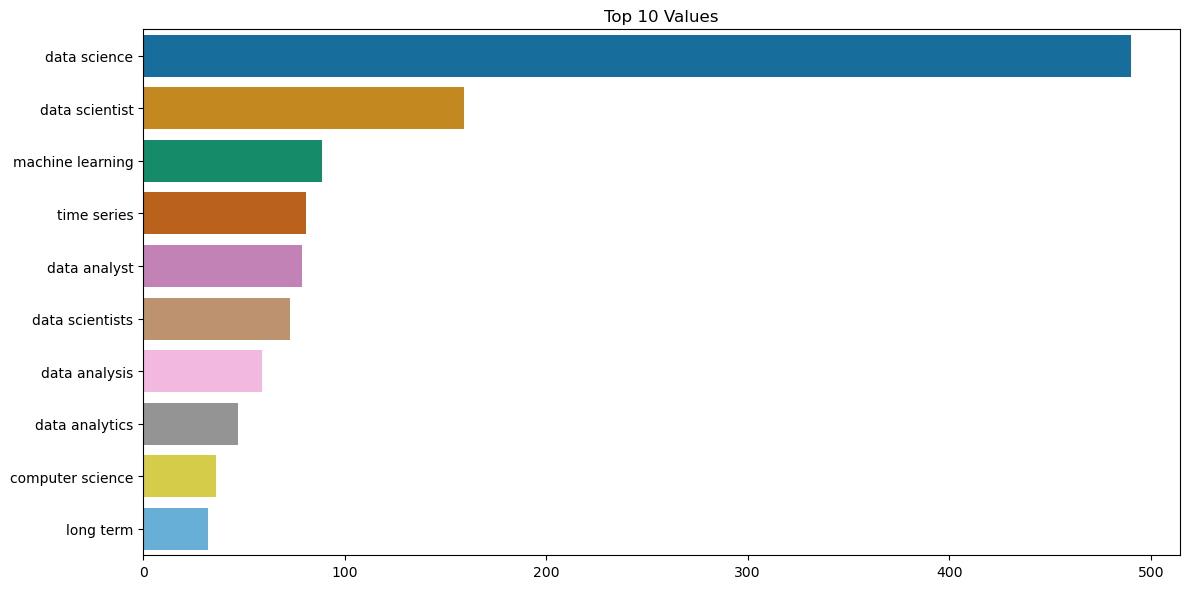  
* WallStreetBets subreddit bigram counts: 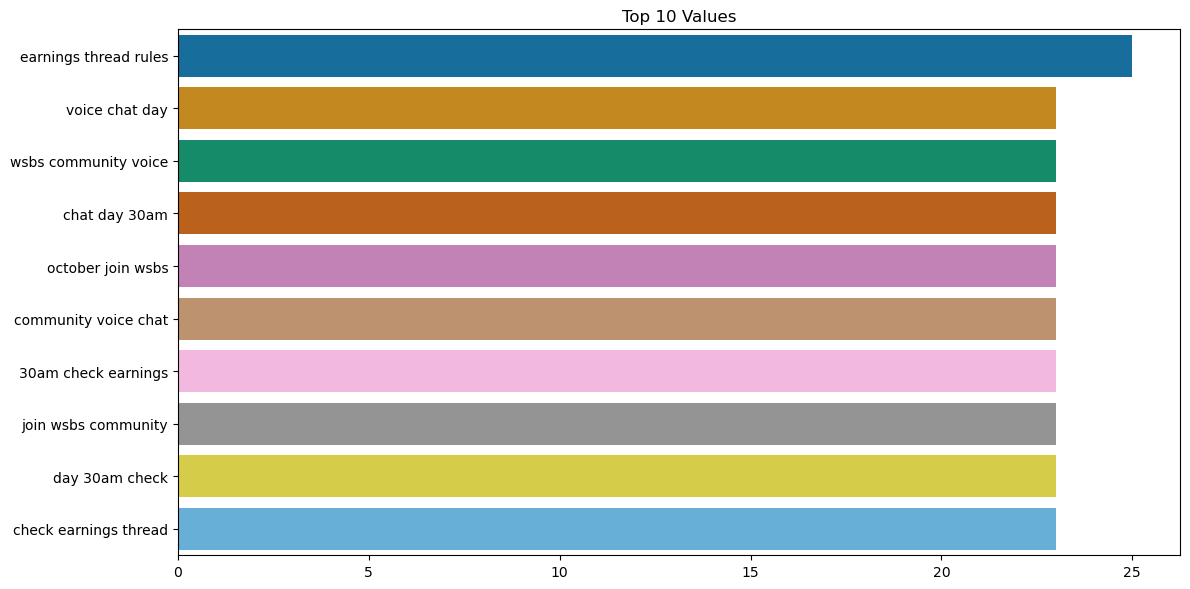  
* We also performed TSNE visualizations and found unigram and bigram features gives the best cluster: 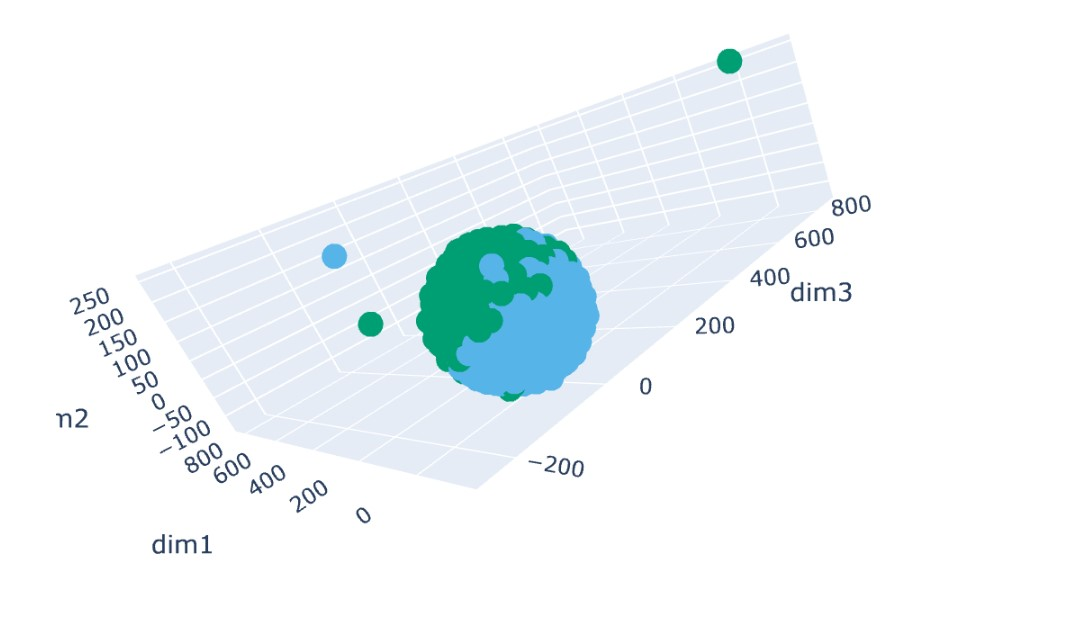

Our best model has accuracy of `> 95%`. 


The classifier we built correctly classifies the post based on the patterns it learned during training. As can be seen in the testing did on made up posts!

| input                                                      | model prediction |
|------------------------------------------------------------|------------------|
| I made $1000 on the stock market today! let's go baby!             | wallstreetbets   |
| How do I remove null objects from my dataset?              | datascience      |
| Guys I need some investment decisions, please help.              | wallstreetbets   |
| I trained a Logistic Regression model to classify the subreddits of a given post.             | datascience      |

